In [2]:
import pandas as pd

# 데이터 호출
m_df = pd.read_csv('./datasets/medical_insurance.csv', low_memory=False)
m_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


#### 📊 데이터 전처리

In [3]:
# 중복행 제거
pre_m_df = m_df.drop_duplicates().reset_index(drop=True)
# 중복행 제거 확인
pre_m_df.duplicated().sum()

0

In [4]:
# 타겟 컬럼 분포 변환
from sklearn.preprocessing import PowerTransformer

ptf = PowerTransformer(standardize=False)
pre_m_df['charges'] = ptf.fit_transform(pre_m_df[['charges']])

In [5]:
from sklearn.preprocessing import LabelEncoder

# 데이터 프레임 복제
enc_m_df = pre_m_df.copy()
encoders = {}

# 문자열 컬럼 추출
columns = ['sex', 'smoker']

# 반복하여 컬럼 인코딩 처리:
for column in columns:
    # 레이블인코더 객체 생성
    encoder = LabelEncoder()
    # 문자열 데이터 정수로 형변환
    result = encoder.fit_transform(enc_m_df[column])
    # 형변환 값으로 대체
    enc_m_df[column] = result
    # 원본 데이터 담기
    encoders[column] = encoder.classes_

In [6]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# 원 핫 인코더 객체 생성
# sparse_output: False = 밀집행렬(실제 값으로 채워진 행렬) 반환
one_hot_encoder = OneHotEncoder(sparse_output=False)
# 지역 피처 인코딩 처리
result = one_hot_encoder.fit_transform(enc_m_df[['region']])

# 인코딩 값 데이터 프레임으로 생성하고 정수로 형변환한 뒤, 기존 데이터 프레임과 병합
enc_m_df = pd.concat([enc_m_df, pd.DataFrame(result, columns=one_hot_encoder.categories_).astype(np.int8)], axis=1)

# 사용이 끝난 데이터 제거
enc_m_df = enc_m_df.drop(labels='region', axis=1)

# 원 핫 인코딩 컬럼명 변경
enc_m_df.rename(columns={
    ('northeast',): 'northeast',
    ('northwest',): 'northwest',
    ('southeast',): 'southeast',
    ('southwest',): 'southwest',
}, inplace=True)

In [7]:
# 타겟 컬럼 위치 변경을 위해 새로운 컬럼에 데이터 담기
enc_m_df['target'] = enc_m_df.charges
# 기존 컬럼은 제거
enc_m_df = enc_m_df.drop(labels='charges', axis=1)

### 🌟 1Cycle

#### 🚩 1Cycle 결과

C:\Users\LEGION\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LEGION\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LEGION\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LEGION\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

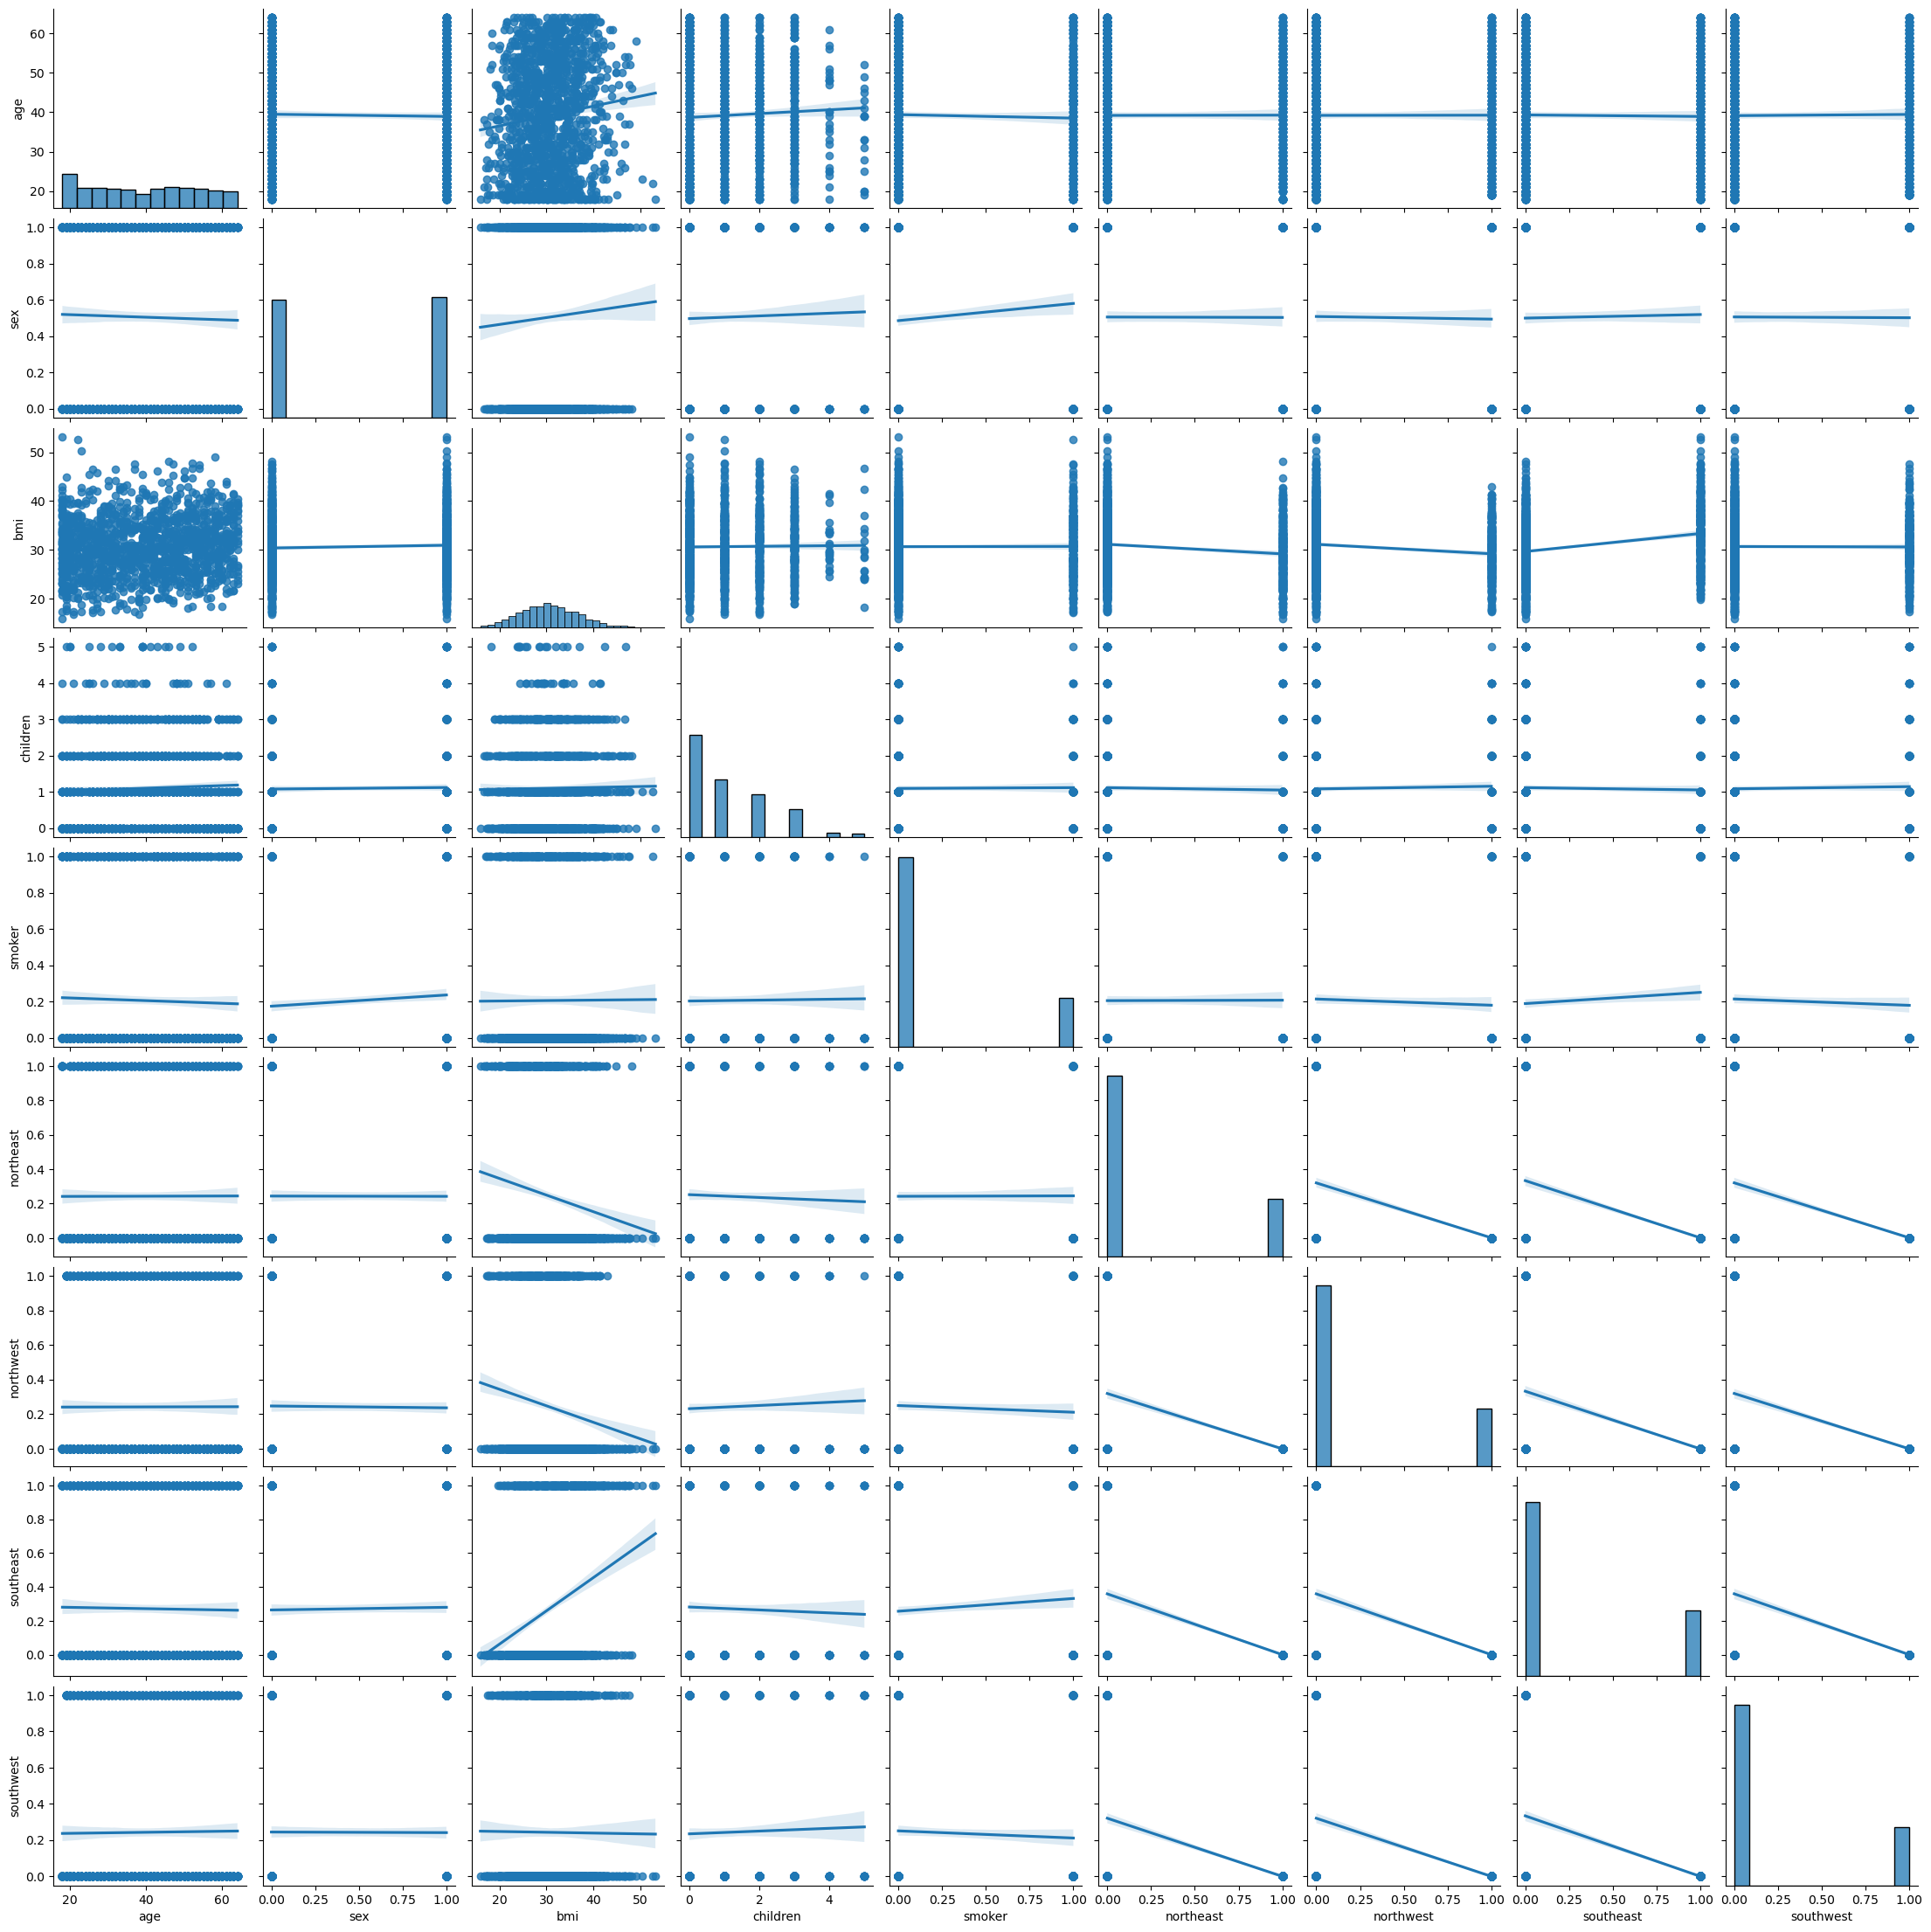

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임에서 'target' 열 제외
columns = ['age', 'sex', 'bmi', 'children', 'smoker', 'northeast', 'northwest', 'southeast', 'southwest']

# 산점도 행렬 시각화
sns.pairplot(enc_m_df[columns], kind="reg")
plt.show()

#### 🚩 결과
변수간에 선형 관계가 있는 것으로 판단됨.
따라서, 선형 패턴을 지닌다고 볼 수 있음.

### 🌟 2Cycle

In [71]:
import numpy as np
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score

def get_evaluation(y_test, prediction):
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    MSLE =  mean_squared_log_error(y_test, prediction)
    RMSLE = np.sqrt(MSLE)
    R2 = r2_score(y_test, prediction)
    print('MSE: {:.4f}, RMSE: {:.4f}, MSLE: {:.4f}, RMSLE: {:.4f}, R2: {:.4f}'\
         .format(MSE, RMSE, MSLE, RMSLE, R2))

In [8]:
from statsmodels.api import OLS

features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

model = OLS(targets, features)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     557.6
Date:                Thu, 09 May 2024   Prob (F-statistic):               0.00
Time:                        16:46:50   Log-Likelihood:                -1325.5
No. Observations:                1337   AIC:                             2669.
Df Residuals:                    1328   BIC:                             2716.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0503      0.001     39.157      0.0

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(features):
    vif = pd.DataFrame()
    vif['vif_score'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif['features']  =  features.columns
    return vif

In [10]:
get_vif(features)

,vif_score,features
0,1.016794,age
1,1.008944,sex
2,1.106742,bmi
3,1.004017,children
4,1.012100,smoker
5,8.603955,northeast
6,8.617019,northwest
7,11.535961,southeast
8,9.219311,southwest


In [11]:
enc_m_df.corr()['target'].sort_values(ascending=False)[1:]

smoker       0.675834
age          0.517764
children     0.155334
bmi          0.135931
northeast    0.040796
southeast    0.018188
sex          0.010037
northwest   -0.016869
southwest   -0.042775
Name: target, dtype: float64

<Axes: >

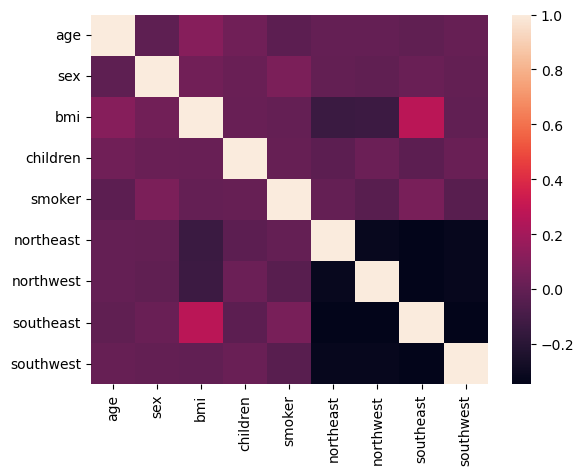

In [12]:
import seaborn as sns

sns.heatmap(features.corr())

#### 🚩 결과
- 상관관계가 낮고 다중 공산성이 높은 피처 제거
- northeast, northwest, southeast, southwest 제거

In [13]:
columns=['northeast', 'northwest', 'southeast', 'southwest', 'sex']

enc_m_df = enc_m_df.drop(columns=columns, axis=1)
enc_m_df

,age,bmi,children,smoker,target
0,19,27.900,0,1,12.112778
1,18,33.770,1,0,8.800475
2,28,33.000,3,0,10.136186
3,33,22.705,0,0,12.517696
4,32,28.880,0,0,9.934782
...,...,...,...,...,...
1332,50,30.970,3,0,11.409771
1333,18,31.920,0,0,9.141534
1334,18,36.850,0,0,8.721757
1335,21,25.800,0,0,9.010493


In [16]:
from statsmodels.api import OLS

features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          1.695e+04
Date:                Thu, 09 May 2024   Prob (F-statistic):                        0.00
Time:                        16:48:42   Log-Likelihood:                         -2495.6
No. Observations:                1337   AIC:                                      4999.
Df Residuals:                    1333   BIC:                                      5020.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'smoker'}>],
       [<Axes: title={'center': 'target'}>, <Axes: >]], dtype=object)

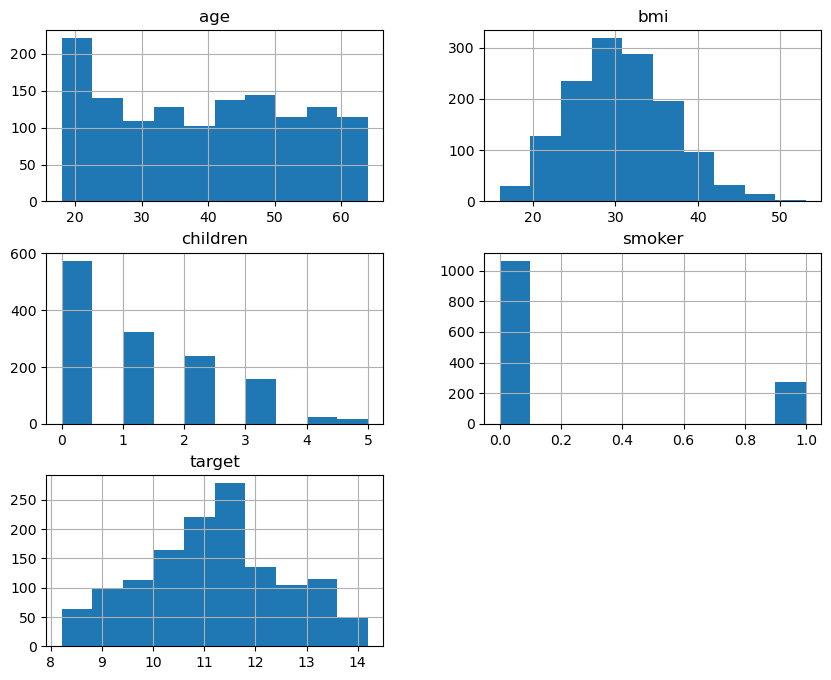

In [14]:
enc_m_df.hist(figsize=(10, 8))

In [15]:
enc_m_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.000000,27.000000,39.000000,51.000000,64.000000
bmi,1337.0,30.663452,6.100468,15.960000,26.290000,30.400000,34.700000,53.130000
children,1337.0,1.095737,1.205571,0.000000,0.000000,1.000000,2.000000,5.000000
smoker,1337.0,0.204936,0.403806,0.000000,0.000000,0.000000,0.000000,1.000000
target,1337.0,11.185657,1.362082,8.211464,10.229296,11.228363,12.092117,14.199598


#### 🚩 결과
- (범주형 데이터 제외)age, bmi는 평균과 중앙값이 거의 유사하므로 이상치 제거를 하지 않음.
- 타겟 데이터의 이상치만 제거하기로 함.

In [ ]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
result = std.fit_transform(enc_m_df[['target']])

std_m_df = enc_m_df.copy()
std_m_df.loc[:, 'target'] = result

std_m_df

In [ ]:
std_m_df[std_m_df.target.between(-1.96, 1.96)].describe().T

In [ ]:
std_m_df = std_m_df[std_m_df.target.between(-1.96, 1.96)]
std_m_df

In [ ]:
enc_m_df = enc_m_df.loc[std_m_df.index].reset_index(drop=True)
enc_m_df

In [ ]:
enc_m_df.hist(figsize=(10, 8))

In [ ]:
from statsmodels.api import OLS

features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

model = OLS(targets, features)
print(model.fit().summary())

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(features):
    vif = pd.DataFrame()
    vif['vif_score'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif['features'] = features.columns
    return vif

In [ ]:
get_vif(features)

In [ ]:
enc_m_df.corr()['target'].sort_values(ascending=False)[1:]